In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import os
import cv2
import glob
import random
import sys

In [258]:
data_dir="asl_alphabet_train"


In [259]:
def count_images_in_folders(directory_path):

    folders = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

    for folder in folders:
        folder_path = os.path.join(directory_path, folder)
        image_files = glob.glob(os.path.join(folder_path, '*.jpg')) + glob.glob(os.path.join(folder_path, '*.png')) 
        image_count = len(image_files)

        print(f"Folder {folder}: {image_count} images")


count_images_in_folders(data_dir)

Folder space: 3000 images
Folder nothing: 3000 images
Folder del: 3000 images
Folder Z: 3000 images
Folder Y: 3000 images
Folder X: 3000 images
Folder W: 3000 images
Folder V: 3000 images
Folder U: 3000 images
Folder T: 3000 images
Folder S: 3000 images
Folder R: 3000 images
Folder Q: 3000 images
Folder P: 3000 images
Folder O: 3000 images
Folder N: 3000 images
Folder M: 3000 images
Folder L: 3000 images
Folder K: 3000 images
Folder J: 3000 images
Folder I: 3000 images
Folder H: 3000 images
Folder G: 3000 images
Folder F: 3000 images
Folder E: 3000 images
Folder D: 3000 images
Folder C: 3000 images
Folder B: 3000 images
Folder A: 3000 images


In [260]:
def print_image(dir):
     folder_path = os.path.join(dir)
     image_files = glob.glob(os.path.join(folder_path, '*.jpg')) + glob.glob(os.path.join(folder_path, '*.png')) 
     l=len(image_files)
     print(l)
     r=int(l/4)
     c=l//4
     print(r,c)
     fig = plt.figure(figsize = (24, 12))
     for i in range(1, l+1):
            img = cv2.imread(image_files[i-1])
            axis=plt.subplot(r, c, i)
            plt.imshow(img)
            plt.title(image_files[i-1].split("/")[-1])
            axis.axis('off')
     plt.show()

28
7 7


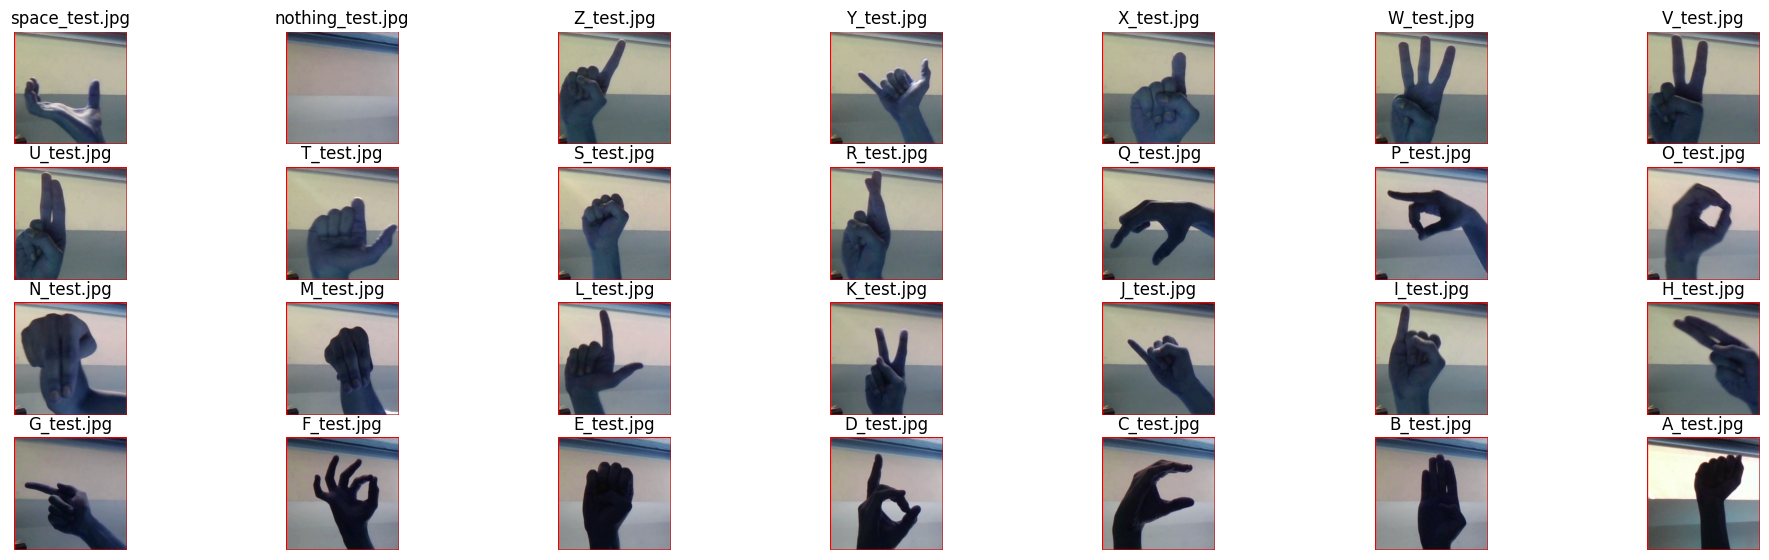

In [261]:
print_image("asl_alphabet_test")

In [262]:
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  
    transforms.Lambda(lambda x: x / 255)  
])
                            

In [263]:

def create_dataloaders(data_dir, transform, batch_size=32, test_split_ratio=0.2, random_seed=42):

    if not os.path.isdir(data_dir):
        raise ValueError(f"The directory {data_dir} does not exist or is not a valid directory.")
    

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    

    total_size = len(dataset)
    test_size = int(total_size * test_split_ratio)
    train_size = total_size - test_size
    
   
    torch.manual_seed(random_seed)
    
   
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


data_directory = "asl_alphabet_train"
batch_size = 32
train_loader, test_loader = create_dataloaders(data_directory, data_transform, batch_size)


print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of testing samples: {len(test_loader.dataset)}")

Number of training samples: 69600
Number of testing samples: 17400


In [264]:


class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=4)
        self.dropout1 = nn.Dropout(0.5)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=4)
        self.dropout2 = nn.Dropout(0.5)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        self.dropout3 = nn.Dropout(0.5)
        self.flatten=nn.Flatten()
     
        self.flatten_size = 256*4*4
        
        # self.lstm = nn.LSTM(input_size=self.flatten_size, hidden_size=128, batch_first=True, dropout=0.5)
        # self.dropout_lstm = nn.Dropout(0.5)
        # self.fc1 = nn.Linear(128, 64)
        # self.fc2 = nn.Linear(64, 29)
        self.fc1 = nn.Linear(self.flatten_size, 29)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.conv5(x))
        x = self.dropout3(x)
        x=self.flatten(x)
      
        # x = x.view(x.size(0), -1)  
        
        # x = x.unsqueeze(1)  
        
       
        # x, _ = self.lstm(x)  
        # x = x[:, -1, :]  
        
        # x = self.dropout_lstm(x)
        

        x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)


model = CNNLSTMModel()
print(model)


CNNLSTMModel(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout3): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=29, bias=True)
)


In [265]:
from torchinfo import summary
summary(model, 
        input_size=(32, 3, 64, 64), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CNNLSTMModel (CNNLSTMModel)              [32, 3, 64, 64]      [32, 29]             --                   True
├─Conv2d (conv1)                         [32, 3, 64, 64]      [32, 64, 64, 64]     4,864                True
├─Conv2d (conv2)                         [32, 64, 64, 64]     [32, 64, 64, 64]     102,464              True
├─MaxPool2d (pool1)                      [32, 64, 64, 64]     [32, 64, 16, 16]     --                   --
├─Dropout (dropout1)                     [32, 64, 16, 16]     [32, 64, 16, 16]     --                   --
├─Conv2d (conv3)                         [32, 64, 16, 16]     [32, 128, 16, 16]    204,928              True
├─Conv2d (conv4)                         [32, 128, 16, 16]    [32, 128, 16, 16]    409,728              True
├─MaxPool2d (pool2)                      [32, 128, 16, 16]    [32, 128, 4, 4]      --                   --
├─Dropout (dropout2)

In [266]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               batch_size: int,
               device) :
    model=model.to(device)
    model.train()

    train_loss, train_acc = 0, 0
    

    for batch_size, (X, y) in enumerate(dataloader):

        X, y = X, y
        X=X.to(device)
        y=y.to(device)
      
        y_pred = model(X)


        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

 
        optimizer.zero_grad()


        loss.backward()

        optimizer.step()


        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [267]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              batch_size: int,
              device):
    model=model.to(device)
    model.eval() 
    

    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for batch_size, (X, y) in enumerate(dataloader):

            X, y = X, y
            X=X.to(device)
            y=y.to(device)

            test_pred_logits = model(X)


            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
     
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [268]:
from tqdm.auto import tqdm


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          batch_size: int = 32,
          device: str= 'cpu'):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,batch_size=batch_size,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,batch_size=batch_size,
            device=device)
        

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

 
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [269]:
torch.manual_seed(42) 



NUM_EPOCHS = 5



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


from timeit import default_timer as timer 
start_time = timer()


model_results = train(model=model, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device="cpu")

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']


    epochs = range(len(results['train_loss']))


    plt.figure(figsize=(15, 7))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [ ]:
plot_loss_curves(model_results)

In [ ]:
model_path = 'model.pth'


torch.save(model.state_dict(), model_path)